# take centered connectivity matrices and compute gradients
baseline as reference

In [204]:
import pandas as pd

from brainspace.gradient import GradientMaps
# this is computed based on `baseline`
ref_cmat = pd.read_csv('data/cmat/ref_mean.csv').to_numpy()

gref = GradientMaps(random_state=42, approach='pca', kernel='cosine')
# kernel needed for centered mats
gref.fit(ref_cmat)

DIR = '/Users/qasem/PycharmProjects/cortical-400-subcortical-RL-task-rest/'
subjects = pd.read_csv(DIR + '_participants.tsv', sep='\t')
subjects = subjects.loc[subjects.exclude == 0, 'participant_id'].tolist()
subjects.remove(37)  # no data available
subjects.remove(25)  # no data available
subjects.remove(36)  # no data available
# print(subjects)

In [3]:
def cmat_cnt(subject, epoch):
    return pd.read_csv('data/cmat/cnt/cnt_'+str(subject)+'_'+epoch+'.csv').to_numpy()

EPOCHS = ['baseline', 'early', 'late']
EPOCH_REF = 'baseline'

g = GradientMaps(random_state=42, approach='pca', alignment='procrustes', kernel='cosine')
g.fit([cmat_cnt(s, e) for e in  EPOCHS for s in subjects],
      reference=gref.gradients_)

assert len(subjects) * len(EPOCHS) == len(g.aligned_)

import numpy as np
print(np.stack(g.aligned_).shape)

GradientMaps(alignment='procrustes', approach='pca', kernel='cosine',
             random_state=42)

In [5]:
regions_nets = pd.read_csv('data/regions_sorted.csv')

dfg = []
for e in EPOCHS:
    for s in subjects:
        subj_epoch_dict = {'subject': s, 'epoch': e, 'region': regions_nets['region'],
                           '7net': regions_nets['7net'], '17net': regions_nets['17net']}
        for n in range(1,10):
            subj_epoch_dict['g'+str(n)] = g.aligned_[EPOCHS.index(e) * len(subjects) + subjects.index(s)][:, n-1]
        dfg.append(pd.DataFrame(subj_epoch_dict))

dfg = pd.concat(dfg, axis=0).reset_index(drop=True)

take top 9 gradients. 10th comes before 2 when sorted as string.

In [205]:
# can find num of regions outside 2 std of mean for each gradient

def get_outliers(df, col):
    return df.loc[(df[col] > df[col].mean() + 2 * df[col].std()) |
                  (df[col] < df[col].mean() - 2 * df[col].std()), 'region'].tolist()

# get_outliers(dfg.loc[1, 'baseline'], 'g2')

for each gradient, take shift that happens from baseline to early, and from early to late. add it to epochs

In [7]:
# dfg.to_csv('data/gradient_10.csv', index=False)
# dfg = pd.read_csv('data/gradient_10.csv')
dfg = dfg.pivot_table(index=['subject', 'region', '7net', '17net'], columns='epoch')

def add_contrasts(df):
    df = df.droplevel(0, axis=1)
    df['b2e'] = df['early'] - df['baseline']
    df['e2l'] = df['late'] - df['early']
    return df

dfg = dfg.groupby(level=0, axis=1).apply(add_contrasts)

dfg.columns.names = ['g', 'epoch']

this contains PC loadings for each subject, region, and epoch (phases of learning; baseline, early, late, and their contrasts)

In [235]:
dfg.head()

g                                                         g1            \
epoch                                               baseline     early   
subject region                   7net 17net                              
1       7Networks_LH_Cont_Cing_1 Cont SalVentAttnB -1.202219 -2.275355   
        7Networks_LH_Cont_Cing_2 Cont ContC         0.132472  0.938163   
        7Networks_LH_Cont_Cing_3 Cont ContC        -0.087299  0.828413   
        7Networks_LH_Cont_Cing_4 Cont ContA        -0.275912 -1.966233   
        7Networks_LH_Cont_Cing_5 Cont ContC        -1.144249 -0.949462   

g                                                                       \
epoch                                                   late       b2e   
subject region                   7net 17net                              
1       7Networks_LH_Cont_Cing_1 Cont SalVentAttnB -1.606757 -1.073136   
        7Networks_LH_Cont_Cing_2 Cont ContC         1.008871  0.805691   
        7Networks_LH_Cont_Cing_3 Cont ContC         0.552762  0.915711   
        7Networks_LH_Cont_Cing_4 Cont ContA        -0.763511 -1.690321   
        7Networks_LH_Cont_Cing_5 Cont ContC         0.702773  0.194787   

g                                                                   g2  \
epoch                                                    e2l  baseline   
subject region                   7net 17net                              
1       7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  0.668598 -0.087578   
        7Networks_LH_Cont_Cing_2 Cont ContC         0.070708 -2.357872   
        7Networks_LH_Cont_Cing_3 Cont ContC        -0.275651 -2.294425   
        7Networks_LH_Cont_Cing_4 Cont ContA         1.202722  0.491095   
        7Networks_LH_Cont_Cing_5 Cont ContC         1.652235 -0.551032   

g                                                                       \
epoch                                                  early      late   
subject region                   7net 17net                              
1       7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  0.495079 -0.889964   
        7Networks_LH_Cont_Cing_2 Cont ContC        -1.750736 -1.231401   
        7Networks_LH_Cont_Cing_3 Cont ContC        -1.870713 -1.713793   
        7Networks_LH_Cont_Cing_4 Cont ContA        -0.659202  0.576098   
        7Networks_LH_Cont_Cing_5 Cont ContC        -1.664575 -1.916185   

g                                                                       ...  \
epoch                                                    b2e       e2l  ...   
subject region                   7net 17net                             ...   
1       7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  0.582656 -1.385043  ...   
        7Networks_LH_Cont_Cing_2 Cont ContC         0.607136  0.519335  ...   
        7Networks_LH_Cont_Cing_3 Cont ContC         0.423712  0.156920  ...   
        7Networks_LH_Cont_Cing_4 Cont ContA        -1.150298  1.235301  ...   
        7Networks_LH_Cont_Cing_5 Cont ContC        -1.113543 -0.251611  ...   

g                                                         g8            \
epoch                                               baseline     early   
subject region                   7net 17net                              
1       7Networks_LH_Cont_Cing_1 Cont SalVentAttnB -1.141151 -1.233259   
        7Networks_LH_Cont_Cing_2 Cont ContC        -0.498305 -1.083918   
        7Networks_LH_Cont_Cing_3 Cont ContC        -0.893721 -1.342777   
        7Networks_LH_Cont_Cing_4 Cont ContA        -0.296966 -1.237815   
        7Networks_LH_Cont_Cing_5 Cont ContC        -0.547759 -0.907812   

g                                                                       \
epoch                                                   late       b2e   
subject region                   7net 17net                              
1       7Networks_LH_Cont_Cing_1 Cont SalVentAttnB -1.094334 -0.092108   
        7Networks_LH_Cont_Cing_2 Cont ContC         0.554168 -0.585613   
        7Networks_LH_Cont_Cing_3

In [39]:
print(dfg.index.names, dfg.columns.names)

['subject', 'region', '7net', '17net'] ['g', 'epoch']


In [18]:
# revert to long format to save
# dfg.stack('epoch').reorder_levels([0, 4, 1, 2, 3]).to_csv('data/gradient_10.csv')
# dfg = pd.read_csv('data/gradient_10.csv', index_col=[0, 1, 2, 3, 4])

In [155]:
import seaborn
import matplotlib.pyplot as plt

seaborn.set_theme(style='whitegrid')
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
seaborn.set_style('white')
seaborn.set_context('paper', font_scale=1.5)

the following seems to be noise. look at the difference between mean and std for each gradient.

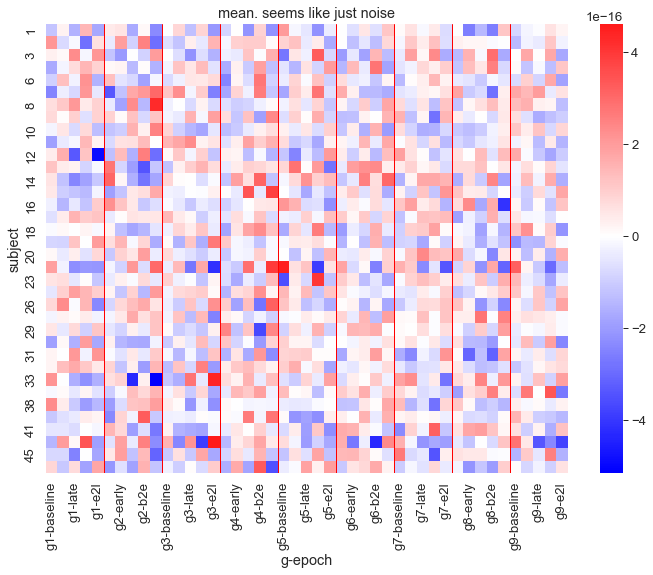

In [156]:
ax = seaborn.heatmap(dfg.groupby('subject').mean(),
                cmap='bwr', center=0)
ax.set_title("mean")
for i in range(1, 10):  ax.axvline(i * 5, color='red', linewidth=1)

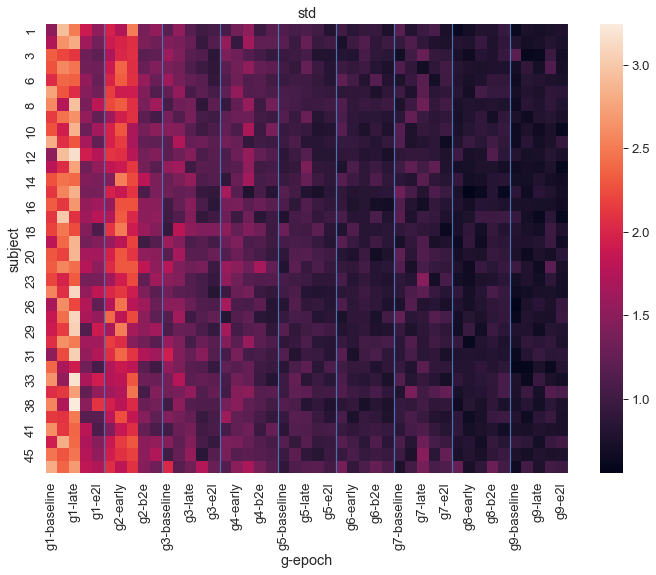

In [157]:
ax = seaborn.heatmap(dfg.groupby('subject').std())
ax.set_title('std')
for i in range(1, 10):  ax.axvline(i * 5)

# any correlation with behavioral task scores?
just to clarify, we had 2 task scores for each subject:
RLScore is the score with fPCA (described in methods), and tscore is the score is simply an unpaired t-test between the late and early learning phases, ie how much they improved throughout learning.

In [159]:
# load learning scores
metrics = pd.read_csv('data/metrics.csv', index_col=3)
metrics

,Subject,tscore,RLScore
subject,,,
1,AB1,-8.686500,-1.179789
2,AG1,-6.485268,1.104018
3,AH1,-2.347640,-0.302101
4,AM1,-6.676496,-1.400917
6,AP1,-16.480796,0.868475
7,AV1,-3.902501,0.859943
8,BN1,-6.263557,1.433999
9,CD1,-10.370127,-0.661215
10,CG1,-4.442353,-0.337563


In [160]:
# print(metrics.corrwith(metrics['RLScore']))

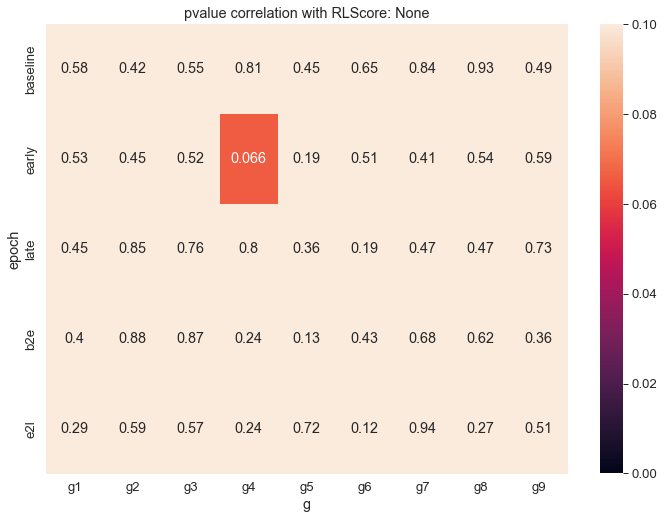

In [168]:
corr_score = dfg.groupby(level='subject').mean().corrwith(metrics['RLScore']).rename('corr_with_RLScore')
pval_score = dfg.groupby(level='subject').mean().corrwith(metrics['RLScore'], method=pval).rename('pval_with_RLScore')
ax = seaborn.heatmap(pval_score.unstack('g'), annot=True, vmin=0, vmax=.1)
ax.set_title('pvalue correlation with RLScore: None')
plt.show()

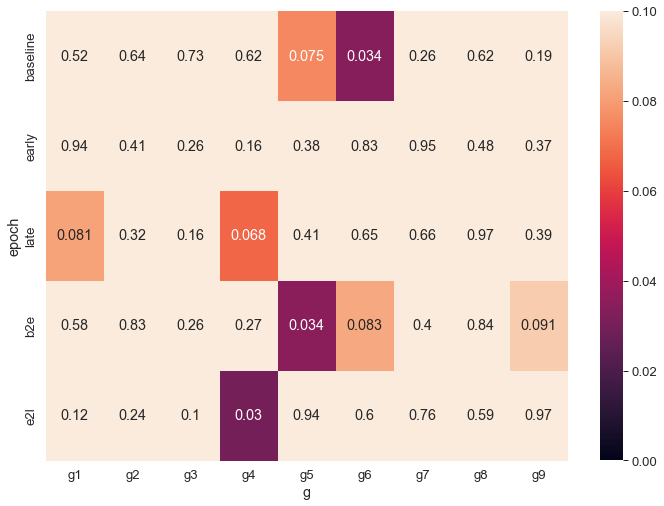

In [243]:
corr_score = dfg.groupby(level='subject').mean().corrwith(metrics['tscore']).rename('corr_with_tscore')
pval_score = dfg.groupby(level='subject').mean().corrwith(metrics['tscore'], method=pval).rename('pval_with_tscore')
ax = seaborn.heatmap(pval_score.unstack('g'), annot=True, vmin=0, vmax=.1)
plt.show()

the following is the correlation between each gradient and the task tscore. there are only 3 significant regions.

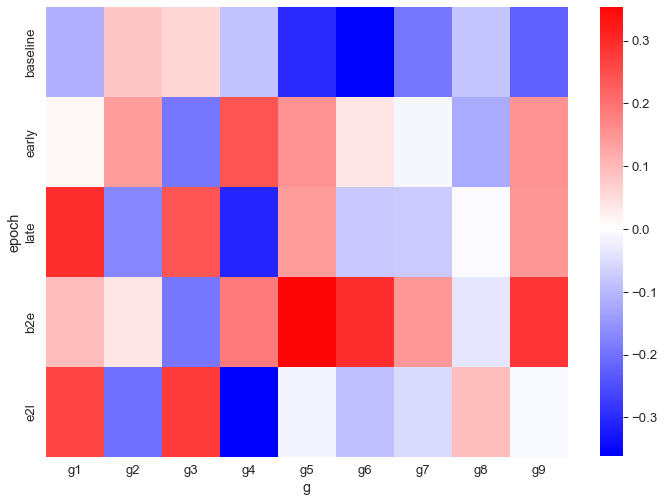

In [244]:
seaborn.heatmap(corr_score.unstack('g'),
                # mask=pval_score.unstack('g') > .05,
                cmap='bwr', center=0)
plt.show()

take mean, median, and std of each gradient/epoch, and see if there is any significance with task scores.

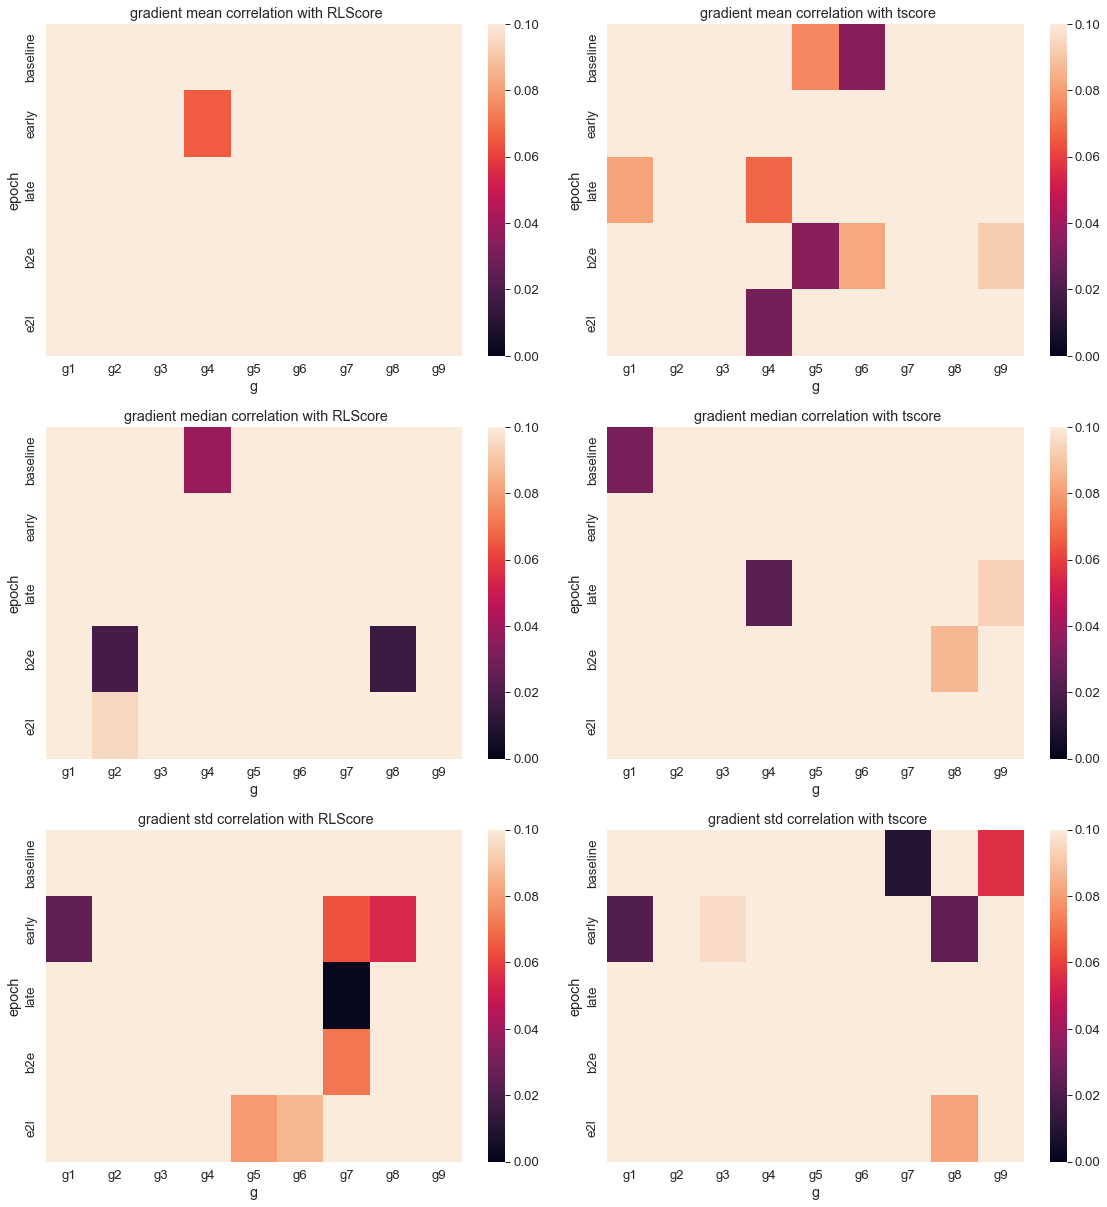

In [234]:
fig, axes = plt.subplots(3,2, figsize=(16, 17))

for i, ax in enumerate(axes.flatten()):
    agg_func = 'mean' if i < 2 else 'median' if i < 4 else 'std'
    metric = 'RLScore' if i%2 == 0 else 'tscore'

    pval_score = dfg.groupby(level='subject').agg(agg_func).corrwith(metrics[metric], method=pval).rename('pval_with_tscore')
    seaborn.heatmap(pval_score.unstack('g'), vmin=0, vmax=.1, ax=ax)
    ax.set_title(f' gradient {agg_func} correlation with {metric}')

plt.tight_layout()
plt.show()

# static 3D plot in top 3 gradients and color with task score
none significant as shown above.

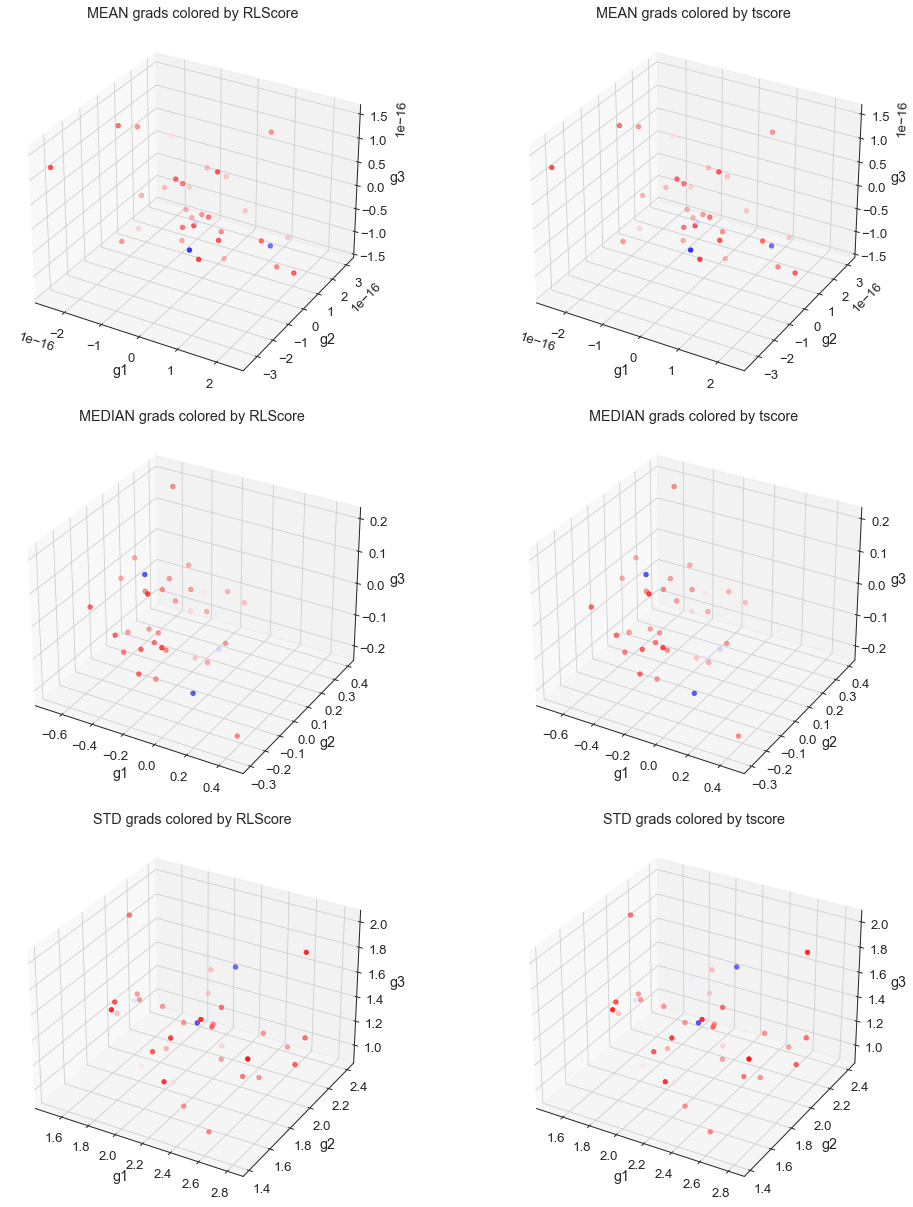

In [281]:
epoch = 'baseline'

fig, axes = plt.subplots(3,2, figsize=(16, 17), subplot_kw={'projection': '3d'})

for i, ax in enumerate(axes.flatten()):
    agg_func = 'mean' if i < 2 else 'median' if i < 4 else 'std'
    metric = 'RLScore' if i%2 == 0 else 'tscore'

    data = dfg.groupby(level='subject').agg(agg_func).xs(epoch, axis=1, level='epoch').join(metrics)

    ax.scatter(data['g1'], data['g2'], data['g3'], c=data['tscore'], cmap='bwr')
    ax.set_xlabel('g1')
    ax.set_ylabel('g2')
    ax.set_zlabel('g3')

    ax.set_title(agg_func.upper() + ' grads colored by ' + metric)

plt.tight_layout()
plt.show()